In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from collections import defaultdict
import heapq
from timeit import default_timer as timer
import math
from pyproj import Proj
import random
%matplotlib inline

In [2]:
G = ox.load_graphml('bolo_30000.graphml')

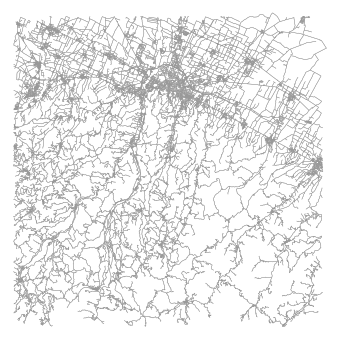

In [3]:
fig, ax = ox.plot_graph(G, node_color = 'w', edge_linewidth=0.4, save = False , file_format = 'png', filename='bolo')

In [4]:
#extract data of nodes and edges

proj_nodes, proj_edges = ox.graph_to_gdfs(G)

In [5]:
#Convert latitude/longitude into UTM coordinates

lat = proj_nodes['y'].tolist()
lon = proj_nodes['x'].tolist()

myProj = Proj("+proj=utm +zone=32, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

x, y = myProj(lon, lat)

In [6]:
#Set the graph

lista_nodi = proj_nodes['osmid'].tolist()
tail = proj_edges['u'].tolist()
head = proj_edges['v'].tolist()
weight = proj_edges['length'].tolist()
coord = {}
my_edges1 = []
my_edges2 = []



j = 0
for i in lista_nodi:
    coord[i] = [x[j], y[j]]
    j = j + 1
    
    
for i in range(len(tail)):
    my_edges1.append([tail[i], head[i], weight[i]])
    my_edges2.append([head[i], tail[i], weight[i]])

graph_1 = defaultdict(list)
for t, h, w in my_edges1:
    graph_1[t].append((h, w))
    
graph_2 = defaultdict(list)
for t, h, w in my_edges2:
    graph_2[t].append((h, w))



In [7]:
print(len(lista_nodi))

28844


In [8]:
def Heap_Dijkstra(graph, source):
    
    distance = {}
    padre = {} 
    for i in lista_nodi:
        distance[i] = 999999
        padre[i] = None
        
    distance[source] = 0
    q = [(0, source)]
    visited = []
    while len(visited) < 20000 :
        
        curr_dist, curr_node = heapq.heappop(q)
        if curr_node not in visited:
            visited.append(curr_node)
            for neighbor, cost in graph[curr_node]:
                if neighbor not in visited:
                    if curr_dist + cost < distance[neighbor]:
                        distance[neighbor]= curr_dist + cost
                        padre[neighbor]= curr_node
                        heapq.heappush(q, (distance[neighbor], neighbor))
                        
    return distance
    
#    parent = [target]
#    num = 0
#    while source not in parent:
#        parent.append(padre[parent[num]])
#        num = num + 1
#    result = parent[::-1]
    
#    print("Amount of visited nodes: " + str(len(visited)))
#    print("Cost: " + str(distance[target]))
#    print("Path: " + str(result))
#    fig, ax = ox.plot_graph_route(G, result, node_color='w')
    
#    nc = ['r' if (node == target) else 'b' if (node in visited) else 'k' for node in G.nodes()]
#    test = [100 if (node == source or node == target) else 3 if (node in visited) else 0 for node in G.nodes()]
#    fig, ax = ox.plot_graph(G, node_size=test, node_color=nc, edge_alpha=0.5, node_zorder = 3)

In [9]:
distanz = Heap_Dijkstra(graph_1, 250762995)

In [10]:
#Set the source and target zones

centro_bolo = []
for i in distanz:
    if 0 < distanz[i] < 1600:
        centro_bolo.append(i)

area_bolo_0 = []
area_bolo_1 = []
area_bolo_2 = []

for i in distanz:
    if 17000 < distanz[i] < 22000:
        area_bolo_0.append(i)
    elif 24000 < distanz[i] < 28000:
        area_bolo_1.append(i)
    elif 29000 < distanz[i] < 32000:
        area_bolo_2.append(i) 

In [11]:
#From the source and target zones, select only southern nodes

m = (max(x) - min(x))/3 + min(x)
M = max(x) - (max(x) - min(x))/3
h = max (y) - (max(y) - min(y))/3
area_bolo_meta_0 = []
area_bolo_meta_1 = []
area_bolo_meta_2 = []

for i in area_bolo_0:
    if m < coord[i][0] < M and coord[i][1] < h:
        area_bolo_meta_0.append(i)
        
for i in area_bolo_1:
    if m < coord[i][0] < M and coord[i][1] < h:
        area_bolo_meta_1.append(i)
        
for i in area_bolo_2:
    if m < coord[i][0] < M and coord[i][1] < h:
        area_bolo_meta_2.append(i)

In [13]:
def Bidirectional_Dijkstra(graph_1, graph_2, source, target):
    
    distance_1 = {}
    distance_2 = {}
    padre_1 = {}
    padre_2 = {}
    visited_1 = []
    visited_2 = []

    for i in lista_nodi:
        distance_1[i] = 99999
        padre_1[i] = None
        distance_2[i] = 99999
        padre_2[i] = None

    distance_1[source] = 0
    distance_2[target] = 0
    q_1 = [(0, source)]
    q_2 = [(0, target)]
    mu = 9999999
    curr_dist_1 = 0
    curr_dist_2 = 0
    while (curr_dist_1 + curr_dist_2 < mu):
        curr_dist_1, curr_node_1 = min_heap(q_1, visited_1)
        visited_1.append(curr_node_1)
        for neighbor, cost in graph_1[curr_node_1]:
            if neighbor not in visited_1:
                if curr_dist_1 + cost < distance_1[neighbor]:
                    distance_1[neighbor]= curr_dist_1 + cost
                    padre_1[neighbor]= curr_node_1
                    heapq.heappush(q_1, (distance_1[neighbor], neighbor))
                    if neighbor in visited_2 and curr_dist_1 + cost + distance_2[neighbor] < mu:
                        mu = curr_dist_1 + cost + distance_2[neighbor]
                        node_in_path = curr_node_1
                        neigh_in_path = neighbor
                        
        curr_dist_2, curr_node_2 = min_heap(q_2, visited_2)
        visited_2.append(curr_node_2)

        for neighbor, cost in graph_2[curr_node_2]:
            if neighbor not in visited_2:
                if curr_dist_2 + cost < distance_2[neighbor]:
                    distance_2[neighbor]= curr_dist_2 + cost
                    padre_2[neighbor]= curr_node_2
                    heapq.heappush(q_2, (distance_2[neighbor], neighbor))
                    if neighbor in visited_1 and curr_dist_2 + cost + distance_1[neighbor] < mu:
                        mu = curr_dist_2 + cost + distance_1[neighbor]
                        node_in_path = neighbor
                        neigh_in_path = curr_node_2
                        
                        
    return len(visited_1 + visited_2)
    
#    rev_path = [node_in_path]
#    k = 0
#    while source not in rev_path:
#        rev_path.append(padre_1[rev_path[k]])
#        k = k + 1
#    path_1 = rev_path[::-1]
#    path_2 = [neigh_in_path]
#    j = 0
#    while target not in path_2:
#        path_2.append(padre_2[path_2[j]])
#        j = j + 1
#    path = path_1 + path_2
    
#    print("Amount of visited nodes: " + str(len(visited_1+visited_2)))
#    print("Cost: " + str(mu))
#    print("Path: " + str(path))
#    fig, ax = ox.plot_graph_route(G, path, node_color='w')

#    nc = ['b' if (node in visited_1) else 'r' if (node in visited_2) else 'w' for node in G.nodes()]
#    test = [100 if (node == source or node == target) else 0 for node in G.nodes()]
#    fig, ax = ox.plot_graph(G, node_size=test, node_color=nc, edge_alpha=0.5, node_zorder = 3)


In [21]:
def Bidirectional_Dijkstra_2(graph_1, graph_2, source, target):
    
    distance_1 = {}
    distance_2 = {}
    padre_1 = {}
    padre_2 = {}
    visited_1 = []
    visited_2 = []

    for i in lista_nodi:
        distance_1[i] = 99999
        padre_1[i] = None
        distance_2[i] = 99999
        padre_2[i] = None

    distance_1[source] = 0
    distance_2[target] = 0
    q_1 = [(0, source)]
    q_2 = [(0, target)]
    mu = 9999999
    curr_dist_1 = 0
    curr_dist_2 = 0
    while (curr_dist_1 + curr_dist_2 < mu):
        if len(q_1) < len(q_2):
            curr_dist_1, curr_node_1 = min_heap(q_1, visited_1)
            visited_1.append(curr_node_1)
            for neighbor, cost in graph_1[curr_node_1]:
                if neighbor not in visited_1:
                    if curr_dist_1 + cost < distance_1[neighbor]:
                        distance_1[neighbor]= curr_dist_1 + cost
                        padre_1[neighbor]= curr_node_1
                        heapq.heappush(q_1, (distance_1[neighbor], neighbor))
                        if neighbor in visited_2 and curr_dist_1 + cost + distance_2[neighbor] < mu:
                            mu = curr_dist_1 + cost + distance_2[neighbor]
                            node_in_path = curr_node_1
                            neigh_in_path = neighbor
        else:                
            curr_dist_2, curr_node_2 = min_heap(q_2, visited_2)
            visited_2.append(curr_node_2)

            for neighbor, cost in graph_2[curr_node_2]:
                if neighbor not in visited_2:
                    if curr_dist_2 + cost < distance_2[neighbor]:
                        distance_2[neighbor]= curr_dist_2 + cost
                        padre_2[neighbor]= curr_node_2
                        heapq.heappush(q_2, (distance_2[neighbor], neighbor))
                        if neighbor in visited_1 and curr_dist_2 + cost + distance_1[neighbor] < mu:
                            mu = curr_dist_2 + cost + distance_1[neighbor]
                            node_in_path = neighbor
                            neigh_in_path = curr_node_2
    return len(visited_1 + visited_2)
#    rev_path = [node_in_path]
#    k = 0
#    while source not in rev_path:
#        rev_path.append(padre_1[rev_path[k]])
#        k = k + 1
#    path_1 = rev_path[::-1]
#    path_2 = [neigh_in_path]
#    j = 0
#    while target not in path_2:
#        path_2.append(padre_2[path_2[j]])
#        j = j + 1
#    path = path_1 + path_2
    
#    print("Amount of visited nodes: " + str(len(visited_1 + visited_2)))
#    print("Cost: " + str(mu))
#    print("Path: " + str(path))
#    fig, ax = ox.plot_graph_route(G, path, node_color='w')

#    nc = ['b' if (node in visited_1) else 'r' if (node in visited_2) else 'k' for node in G.nodes()]
#    test = [100 if (node == source or node == target) else 3 if (node in visited_1 or node in visited_2) else 0 for node in G.nodes()]
#    fig, ax = ox.plot_graph(G, node_size=test, node_color=nc, edge_alpha=0.4, node_zorder = 3, save = False , file_format = 'png', filename='bolo_B_lontano')


In [15]:
#Heuristic functions

def min_heap(heap, visited):
    bool = True
    while bool:
        dist, node = heapq.heappop(heap)
        if node not in visited:
            bool = False
    return dist, node

def euclidian_distance(x_1,y_1,x_2,y_2):
    return math.sqrt((x_1-x_2)**2 + (y_1-y_2)**2)

def cebysev_distance(x_1,y_1,x_2,y_2):
    return max(abs(x_1 - x_2), abs(y_1 - y_2))

def euclidian(node, target):
    return euclidian_distance(coord[node][0], coord[node][1], coord[target][0], coord[target][1])
        
def cebysev(node, target):
    return cebysev_distance(coord[node][0], coord[node][1], coord[target][0], coord[target][1])

#def manhattan_distance(x_1,y_1,x_2,y_2):
#    return abs(x_1 - x_2) + abs(y_1 - y_2)

#def manhattan(node, target):
#    return manhattan_distance(coord[node][0], coord[node][1], coord[target][0], coord[target][1])

In [17]:
def Astar(graph, source, target, r):
    
    distance = {}
    padre = {}

    for i in lista_nodi:
        distance[i] = 999999
        padre[i] = None

    distance[source] = 0
    visited = []
    q = [(0, source)]
    while target not in visited:
        curr_dist, curr_node = heapq.heappop(q)
        if curr_node not in visited:
            visited.append(curr_node)
            for neighbor, cost in graph[curr_node]:
                if neighbor not in visited:
                    if distance[curr_node] + cost < distance[neighbor]:
                        distance[neighbor]= distance[curr_node] + cost
                        padre[neighbor]= curr_node
                        heuristic = r(neighbor, target)
                        heapq.heappush(q, (distance[neighbor] + heuristic, neighbor))

    return len(visited)
#    parent = [target]
#    num = 0
#    while source not in parent:
#        parent.append(padre[parent[num]])
#        num = num + 1
#    result = parent[::-1]
   
#    print("Amount of visited nodes: " + str(len(visited)))
#    print("Cost: " + str(distance[target]))
#    print("Path: " + str(result))
#    fig, ax = ox.plot_graph_route(G, result, node_color='w')

    
#    nc = ['r' if (node == target) else 'b' if (node in visited) else 'k' for node in G.nodes()]
#    test = [100 if (node == source or node == target) else 3 if (node in visited) else 0 for node in G.nodes()]
#    fig, ax = ox.plot_graph(G, node_size=test, node_color=nc, edge_alpha=0.4, node_zorder = 3, save = False , file_format = 'png', filename='bolo_A_lontano')



In [73]:
#Create problem sets from source and target zones

problem_set_0 = []
problem_set_1 = []
problem_set_2 = []

for i in range(10):
    problem_set_0.append((random.choice(centro_bolo), random.choice(area_bolo_meta_0)))
    problem_set_1.append((random.choice(centro_bolo), random.choice(area_bolo_meta_1)))
    problem_set_2.append((random.choice(centro_bolo), random.choice(area_bolo_meta_2)))

In [40]:
#Tests problem set 0

nodes_A = []

start = timer()
for problem in problem_set_0:
    nodes_A.append(Astar(graph_1, problem[0], problem[1], euclidian))
end = timer()
print("A star visited: " + str(sum(nodes_A)/len(nodes_A)) + " nodes, in " + str((end - start)/len(problem_set_0)) + " sec")

nodes_A2 = []

start = timer()
for problem in problem_set_0:
    nodes_A2.append(Astar(graph_1, problem[0], problem[1], cebysev))
end = timer()

print("A star2 visited: " + str(sum(nodes_A2)/len(nodes_A2)) + " nodes, in " + str((end - start)/len(problem_set_0)) + " sec")

nodes_BD1 = []

start = timer()
for problem in problem_set_0:
    nodes_BD1.append(Bidirectional_Dijkstra(graph_1, graph_2, problem[0], problem[1]))
end = timer()

print("BD1 visited: " + str(sum(nodes_BD1)/len(nodes_BD1)) + " nodes, in " + str((end - start)/len(problem_set_0)) + " sec")

nodes_BD2 = []

start = timer()
for problem in problem_set_0:
    nodes_BD2.append(Bidirectional_Dijkstra_2(graph_1, graph_2, problem[0], problem[1]))
end = timer()

print("BD2 visited: " + str(sum(nodes_BD2)/len(nodes_BD2)) + " nodes, in " + str((end - start)/len(problem_set_0)) + " sec")
#bolo 1

A star visited: 3836.55 nodes, in 1.0992675200000046 sec
A star2 visited: 5079.366666666667 nodes, in 1.8914363666666683 sec
BD1 visited: 4626.2 nodes, in 0.7976121366666727 sec
BD2 visited: 4544.566666666667 nodes, in 0.8013847433333315 sec


In [39]:
#Test problem set 1
nodes_A = []

start = timer()
for problem in problem_set_1:
    nodes_A.append(Astar(graph_1, problem[0], problem[1], euclidian))
end = timer()
print("A star visited: " + str(sum(nodes_A)/len(nodes_A)) + " nodes,  in " + str((end - start)/len(problem_set_1)) + " sec")

nodes_A2 = []

start = timer()
for problem in problem_set_1:
    nodes_A2.append(Astar(graph_1, problem[0], problem[1], cebysev))
end = timer()

print("A star2 visited: " + str(sum(nodes_A2)/len(nodes_A2)) + " nodes, in " + str((end - start)/len(problem_set_1)) + " sec")

nodes_BD1 = []

start = timer()
for problem in problem_set_1:
    nodes_BD1.append(Bidirectional_Dijkstra(graph_1, graph_2, problem[0], problem[1]))
end = timer()

print("BD1 visited: " + str(sum(nodes_BD1)/len(nodes_BD1)) + " nodes,     in " + str((end - start)/len(problem_set_1)) + " sec")

nodes_BD2 = []

start = timer()
for problem in problem_set_1:
    nodes_BD2.append(Bidirectional_Dijkstra_2(graph_1, graph_2, problem[0], problem[1]))
end = timer()

print("BD2 visited: " + str(sum(nodes_BD2)/len(nodes_BD2)) + " nodes,     in " + str((end - start)/len(problem_set_1)) + " sec")
#bolo 2

A star visited: 5697.583333333333 nodes,  in 2.407164646666668 sec
A star2 visited: 6857.283333333334 nodes, in 3.6099835266666633 sec
BD1 visited: 5491.633333333333 nodes,     in 1.1668167050000042 sec
BD2 visited: 5445.716666666666 nodes,     in 1.1831800783333317 sec


In [38]:
#Test problem set 2
nodes_A = []

start = timer()
for problem in problem_set_2:
    nodes_A.append(Astar(graph_1, problem[0], problem[1], euclidian))
end = timer()
print("A star visited: " + str(sum(nodes_A)/len(nodes_A)) + " nodes, in " + str((end - start)/len(problem_set_2)) + " sec")

nodes_A2 = []

start = timer()
for problem in problem_set_2:
    nodes_A2.append(Astar(graph_1, problem[0], problem[1], cebysev))
end = timer()

print("A star2 visited: " + str(sum(nodes_A2)/len(nodes_A2)) + " nodes, in " + str((end - start)/len(problem_set_2)) + " sec")

nodes_BD1 = []

start = timer()
for problem in problem_set_2:
    nodes_BD1.append(Bidirectional_Dijkstra(graph_1, graph_2, problem[0], problem[1]))
end = timer()

print("BD1 visited: " + str(sum(nodes_BD1)/len(nodes_BD1)) + " nodes, in " + str((end - start)/len(problem_set_2)) + " sec")

nodes_BD2 = []

start = timer()
for problem in problem_set_2:
    nodes_BD2.append(Bidirectional_Dijkstra_2(graph_1, graph_2, problem[0], problem[1]))
end = timer()

print("BD2 visited: " + str(sum(nodes_BD2)/len(nodes_BD2)) + " nodes, in " + str((end - start)/len(problem_set_2)) + " sec")
#bolo 3

A star visited: 5967.3 nodes, in 2.782212439999997 sec
A star2 visited: 6976.566666666667 nodes, in 3.8633317100000037 sec
BD1 visited: 6676.866666666667 nodes, in 1.6405876883333348 sec
BD2 visited: 6412.3 nodes, in 1.479763543333335 sec


In [74]:
# Arrays of sources and targets randomly seclected from problem sets

sorg0 = []
dest0 = []
sorg1 = []
dest1 = []
sorg2 = []
dest2 = []
for problem in problem_set_0:
    sorg0.append(problem[0])
    dest0.append(problem[1])
    
for problem in problem_set_1:
    sorg1.append(problem[0])
    dest1.append(problem[1])
    
for problem in problem_set_2:
    sorg2.append(problem[0])
    dest2.append(problem[1])

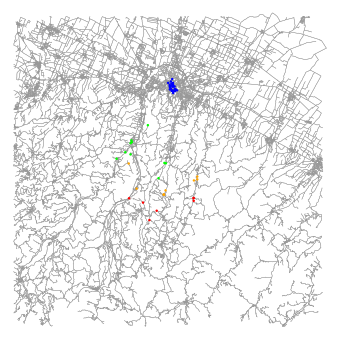

In [75]:
#Plot nodes randomly chosen used in test 

a = [6 if (node in sorg0 or node in sorg1 or node in sorg2 or node in dest0 or node in dest1 or node in dest2) else 0 for node in G.nodes()]
nc = ['b' if (node in sorg0 or node in sorg1 or node in sorg2) else 'lime' if (node in dest0) else 'orange' if (node in dest1) else 'r' if (node in dest2) else 'k' for node in G.nodes()]
fig, ax = ox.plot_graph(G,node_size=a, node_color=nc, edge_linewidth = 0.4, node_zorder = 3)

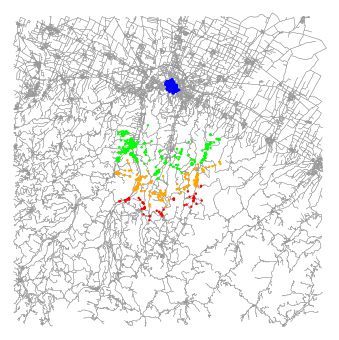

In [12]:
#Plot ploblem sets

a = [6 if (node in centro_bolo) else 6 if (node in area_bolo_meta_0 or node in area_bolo_meta_1 or node in area_bolo_meta_2) else 0 for node in G.nodes()]
nc = ['b' if (node in centro_bolo) else 'lime' if (node in area_bolo_meta_0) else 'orange' if (node in area_bolo_meta_1) else 'r' if (node in area_bolo_meta_2) else 'k' for node in G.nodes()]
fig, ax = ox.plot_graph(G,node_size=a, node_color=nc, edge_linewidth = 0.4, node_zorder = 3, save = False , file_format = 'png', filename='bolo_full')

Amount of visited nodes: 5499
Cost: 25480.97999999999


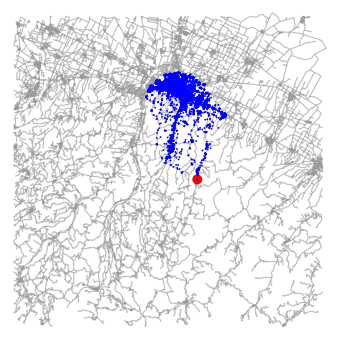

In [16]:
#Astar in problem set 1
Astar(graph_1, 250763742, 1506394989, euclidian)

Amount of visited nodes: 5876
Cost: 29744.838999999993


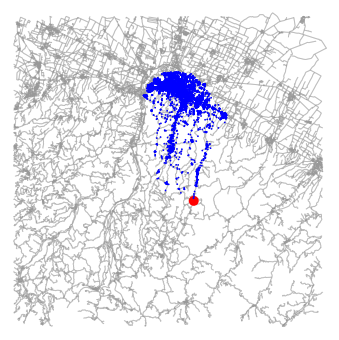

In [18]:
#Astar in problem set 2
Astar(graph_1, 250763742, 278218510, euclidian)

Amount of visited nodes: 5102
Cost: 25480.979999999996


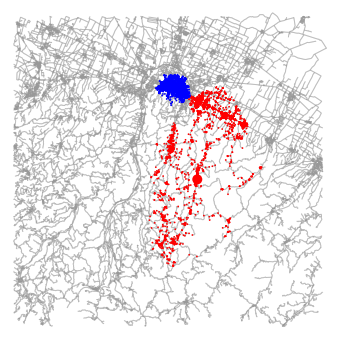

In [20]:
#Bidirectional Dijkstra in problem set 1
Bidirectional_Dijkstra_2(graph_1, graph_2, 250763742, 1506394989)

Amount of visited nodes: 6526
Cost: 29744.839000000004


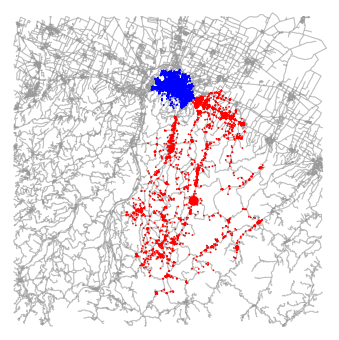

In [22]:
#Bidirectional Dijkstra in problem set 2
Bidirectional_Dijkstra_2(graph_1, graph_2, 250763742, 278218510)

In [3]:
#Stats of the graph

stats = ox.basic_stats(G)
print(stats)

{'n': 28844, 'm': 63550, 'k_avg': 4.40646234918874, 'intersection_count': 22431, 'streets_per_node_avg': 2.6224171404798224, 'streets_per_node_counts': {0: 0, 1: 6413, 2: 250, 3: 20069, 4: 2048, 5: 55, 6: 9}, 'streets_per_node_proportion': {0: 0.0, 1: 0.22233393426709194, 2: 0.008667313826099015, 3: 0.6957772847039245, 4: 0.07100263486340314, 5: 0.0019068090417417834, 6: 0.00031202329773956453}, 'edge_length_total': 15643579.59199993, 'edge_length_avg': 246.16175597167472, 'street_length_total': 8424955.744999958, 'street_length_avg': 222.69390317720337, 'street_segments_count': 37832, 'node_density_km': None, 'intersection_density_km': None, 'edge_density_km': None, 'street_density_km': None, 'circuity_avg': 1.1788221425824654, 'self_loop_proportion': 0.004972462627852085, 'clean_intersection_count': None, 'clean_intersection_density_km': None}
